# degaussing_demo.ipynb
The purpose of this notebook is to demonstrate the application of hysteresis dynamics using ```rsradia``` in order to simulate degaussing for magnets of several geometries, including a parameterized H dipole steering magnet.

In [1]:
#%pip install git+https://github.com/radiasoft/rsradia.git

from numpy import array, zeros, exp, sin, cos, pi
from matplotlib import pyplot as plt
from rsradia.hysteresis import MU0, JilesAtherton
from rsradia.magnets import Block, HDipole

ModuleNotFoundError: No module named 'rsradia.hysteresis'

## Creating a simple block magnet
In this cell we create a simple block magnet with a racetrack coil. First we define the magnet's geometric parameters (in this case, using a dicitonary), then we construct the magnet, and finally we create and show a display for the magnet using a RadiaViewer window.

In [ ]:
# Define parameters for & construct a block magnet
block_params = {
    'center': [0, 0, 0],
    'block_dims': [100, 100, 100],
    'coil_inner': 0,
    'coil_thickness': 10,
    'coil_gap': 5,
}
block_magnet = Block(**block_params)
block_magnet.display()

## Defining a hysteresis model
In the following cell, we define a Jiles-Atherton magnetic hysteresis model for low-carbon steel by loading it from memory. Since we're working with an isotropic material, we can re-use the same model to describe magnetization in all three spatial dimensions.

In [ ]:
# Load a Jiles-Atherton hysteresis model for low-carbon steel
ja_model = JilesAtherton.load("ja-model_g20-steel")

# Plot the example hysteresis quantities for the Jiles-Atherton model
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(r"Magnetic Hysteresis, Low Carbon Steel", fontsize=20, y=.98)
ax.plot(ja_model.H_major, ja_model.B_major, 'k', lw=2, label=r"Major Loop")
ax.axis(1.1*array([ja_model.H_major.min(), ja_model.H_major.max(), ja_model.B_major.min(), ja_model.B_major.max()]))
ax.set_xlabel(r"Magnetizing Field, $H\ (A / m)$", fontsize=18, labelpad=10)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B\ (T)$",fontsize=18)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()

## Defining a series of applied currents
The functions defined in the following cell describe the currents applied to the coils around each pole as functions of time. The cells below set current parameters then compute & plot the corresponding applied currents at various times

In [ ]:
# Describes an applied current profile for simulating degaussing
def I_app(t, t0h, t1h, t0d, I0h, I0d, w, f, rho):
    
    # Step current applied to reach a hysteretic state
    Ih = I0h*(1/(1+exp(rho*(t0h-t)))+1/(1+exp(rho*(t-t1h)))-1)
    
    # Oscillating current applied during degaussing
    Id = (I0d*exp(-w*(t-t0d))*cos(2*pi*f*(t-t0d)))/(1+exp(-rho*(t-t0d)))
    
    return Ih+Id

# Define time parameters
t0h = 0.5 # Hysteretic current switch-on midpoint
t1h = 1 # # Hysteretic current switch-off midpoint
t0d = 2 # Degaussing switch-on
tmax = 5 # Maximum simulation time

# Define current parameters
I0h = 500 # Applied current reaching hysteretic state
I0d = 5 # Maximum applied current during degaussing
rho = 50 # Current switching rate 
f = 5 # Current oscillation frequency during degaussing
w = 1 # Current decay parameter during degaussing

# Define applied currents over a specified range of times
ts = array(range(0, 500))*tmax/500
Icoil = I_app(ts, t0h, t1h, t0d, I0h, I0d, w, f, rho)

fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle("Applied Current Profile\n", fontsize=24, y=.98)
ax.plot(ts, Icoil,'k', lw=2)
ax.text(1, I0h, "Forming hysteretic state", va='center', ha='left', color='k', fontsize=16)
ax.text(2.1, I0h/10, "Performing degaussing", va='center', ha='left', color='k', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_xlabel("Time, s", fontsize=20)
ax.set_ylabel("I(t), A", fontsize=20, labelpad=10)
plt.axis([0,5,-1.5*I0d,1.1*Icoil.max()])
plt.show()

## Degaussing the block magnet
The next cell performs simulated degaussing of the cubic magnet. This is done by looping over applied currents, passing them through the coil, computing resulting magnetic fields, and finally using the hysteresis model to determine field strengths (due to magnetization) in the cube.

In [ ]:
# Define arrays to contain the results of simulated degaussing
H_block = zeros((len(ts), 3))
B_block = zeros((len(ts), 3))

# Loop over current values & apply them to the magnet
A_coil = (block_params['coil_thickness']*block_params['block_dims'][2])    
for t in range(len(ts)):
    Jcoil = Icoil[t]/A_coil
    H_block[t], B_block[t] = block_magnet.magnetize(Jcoil, ja_model)

This cell just defines some magnetic quantities at important points during simulated degaussing to use in plotting. The next cell plots the hysteresis curve of the cubic magnet during degaussing, 

In [2]:
# Store quantities at the initial state for plotting
iniH = H_block[0, 2]
iniB = B_block[0, 2]

# Store quantities at the saturated state for plotting
satID = ts==(t0h+t1h)/2
satH = H_block[:, 2][satID]
satB = B_block[:, 2][satID]

# Store quantities at the hysteretic state for plotting
hystID = ts==(t1h+t0d)/2
hystH = H_block[:, 2][hystID]
hystB = B_block[:, 2][hystID]

# Store quantities at the stopping point for plotting
finH = H_block[-1, 2]
finB = B_block[-1, 2]

# Compute the percentage degaussing percentage metric
percDG = (1-abs(finB)/hystB)*100

# Plot the example hysteresis quantities for the Jiles-Atherton model
fig, ax = plt.subplots(figsize=(11,7))
fig.suptitle(r"Degaussing, Low-Carbon Steel Block", fontsize=20, y=.96)
dgLine, = ax.plot(H_block[:,2], B_block[:,2], lw=2.5)
ax.plot(iniH, iniB, 'bo', mfc='none', ms=10, mew=2.5, label='\nInitial State\n')
ax.plot(hystH, hystB, 'go', mfc='none', ms=10, mew=2.5, label='Hysteretic State')
ax.plot(satH, satB, 'o', color='orange', mfc='none', ms=10, mew=2.5, label='\nSaturated State\n')
ax.plot(finH, finB, 'ro', mfc='none', ms=10, mew=2.5, label='Final State')
leg = ax.legend(loc='lower right', fontsize=16, ncol=2, framealpha=0)
leg.set_title("Critical Points", prop={"size":16, "weight":"bold"})
ax.text(.75*H_block.max(), .85*B_block[:,2].max(), r"Results", ha='center', va='center', fontsize=16, weight="bold")
ax.text(.75*H_block[:,2].max(), .75*B_block[:,2].max(), r"Remanent Field: %.3f"%hystB, ha='center', va='center', fontsize=16)
ax.text(.75*H_block[:,2].max(), .65*B_block[:,2].max(), r"Degaussed Field: %.3f"%finB, ha='center', va='center', fontsize=16)
ax.text(.75*H_block[:,2].max(), .55*B_block[:,2].max(), r"Degaussing: %.1f%%"%percDG, ha='center', va='center', fontsize=16)
ax.axis(1.1*array([H_block[:,2].min(), H_block[:,2].max(), B_block[:,2].min()-.025, 1.01*B_block[:,2].max()]))
ax.set_xlabel(r"Magnetizing Field, $H\ (A / m)$", fontsize=18, labelpad=10)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B\ (T)$",fontsize=18, labelpad=10)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()

NameError: name 'H_block' is not defined

## Degaussing vs. applied current
The following cells repeat the process shown above for many values of the initial degaussing current, ``I0d``.

In [7]:
# Loop over initial degaussing currents from 0-20 Amp
I0ds = 0+50*array(range(50))/50
percDGs = zeros(len(I0ds))
for i in range(len(I0ds)):
    Icoil_i = I_app(ts, t0h, t1h, t0d, I0h, I0ds[i], w, f, rho)

    # Loop over current values & apply them to the magnet
    block_magnet = Block(**block_params)
    for t in range(len(ts)):
        Jcoil = Icoil_i[t]/A_coil
        H, B = block_magnet.magnetize(Jcoil, ja_model)
        
        # Store magnetic flux density at the hysteretic state
        if ts[t]==(t1h+t0d)/2: hystB = B

    # Store magnetic flux density at the stopping point
    finB = B
    
    # Compute the percentage degaussing metric
    percDGs[i] = (1-abs(finB[2])/hystB[2])*100

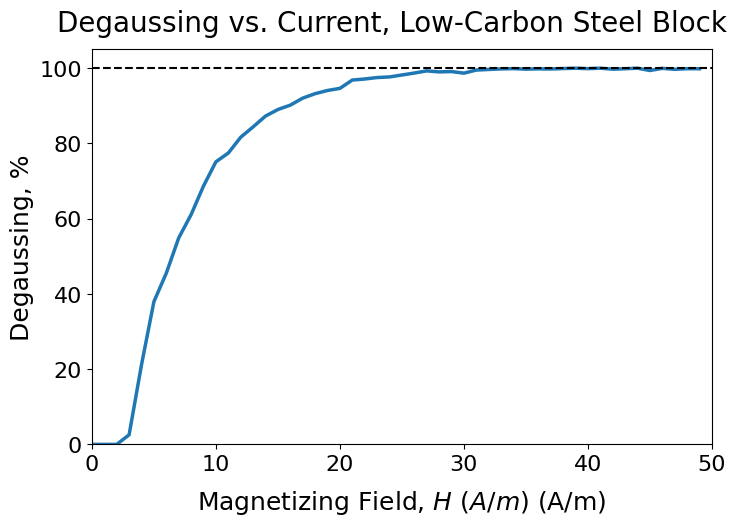

In [8]:
# Plot the example hysteresis quantities for the Jiles-Atherton model
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(r"Degaussing vs. Current, Low-Carbon Steel Block", fontsize=20, y=.98)
ax.plot(I0ds, percDGs,lw=2.5)
ax.plot([0,50],[100,100], 'k--')
ax.axis([0, 50, 0, 105])
ax.set_ylabel(r"Degaussing, %",fontsize=18)
ax.set_xlabel(r"Magnetizing Field, $H\ (A / m)$ (A/m)", fontsize=18, labelpad=10)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()

## Creating an H-dipole
The cells below define the H-dipole geometry, construct the magnet as a series of Radia objects, and visualizes the system using a Radia viewer window.

In [9]:
# Define geometric parameters for the H-dipole
dipole_params = {
    'x_center': 0.,
    'length': 75.,
    'pole_height': 50.,
    'pole_width': 25.,
    'pole_sep': 10.,
    'gap_height': 10.,
    'top_height': 15,
    'leg_width': 10.,
    'coil_inner': 0.1,
    'x_div': 4,
}

# Construct the H-dipole
hdipole = HDipole(**dipole_params)
hdipole.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

## Degaussing the H-dipole

In [10]:
# Define a current profile to apply to the H-dipole
I0d = 3
f = 3
Icoil = I_app(ts, t0h, t1h, t0d, I0h, I0d, w, f, rho)

# Define arrays to contain the results of simulated degaussing
H_dipole = zeros((len(ts), 3))
B_dipole = zeros((len(ts), 3))

# Loop over current values & apply them to the magnet
coil_rfactor = .85
coil_hfactor = .75
A_coil = (dipole_params['pole_sep']*coil_rfactor-dipole_params['coil_inner'])*(dipole_params['pole_height']*coil_hfactor)
for t in range(len(ts)):
    Jcoil = Icoil[t]/A_coil
    H_dipole[t], B_dipole[t] = hdipole.magnetize(Jcoil, ja_model)
    if not t%50: print("{:.1f} out of {:.1f} s".format(ts[t], tmax))

0.0 out of 5.0 s
0.5 out of 5.0 s
1.0 out of 5.0 s
1.5 out of 5.0 s
2.0 out of 5.0 s
2.5 out of 5.0 s
3.0 out of 5.0 s
3.5 out of 5.0 s
4.0 out of 5.0 s
4.5 out of 5.0 s


In [ ]:
# Store quantities at the initial state for plotting
iniH = H_dipole[0, 2]
iniB = B_dipole[0, 2]

# Store quantities at the saturated state for plotting
satID = ts==(t0h+t1h)/2
satH = H_dipole[:, 2][satID]
satB = B_dipole[:, 2][satID]

# Store quantities at the hysteretic state for plotting
hystID = ts==(t1h+t0d)/2
hystH = H_dipole[:, 2][hystID]
hystB = B_dipole[:, 2][hystID]

# Store quantities at the stopping point for plotting
finH = H_dipole[-1, 2]
finB = B_dipole[-1, 2]

# Compute the percentage degaussing percentage metric
percDG = (1-abs(finB)/hystB)*100

# Plot the example hysteresis quantities for the Jiles-Atherton model
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(r"Degaussing, Low-Carbon Steel Block", fontsize=20, y=.96)
dgLine, = ax.plot(H_dipole[:,2], B_dipole[:,2], lw=2.5)
ax.plot(iniH, iniB, 'bo', mfc='none', ms=10, mew=2.5, label='Initial State')
ax.plot(hystH, hystB, 'go', mfc='none', ms=10, mew=2.5, label='\nHysteretic State\n')
#ax.plot(satH, satB, 'o', color='orange', mfc='none', ms=10, mew=2.5, label='\nSaturated State\n')
ax.plot(finH, finB, 'ro', mfc='none', ms=10, mew=2.5, label='Final State')
leg = ax.legend(loc='lower right', fontsize=16, ncol=1, framealpha=0)
leg.set_title("Critical Points", prop={"size":16, "weight":"bold"})
ax.text(.0031, .8*B_dipole[:,2].max(), r"Results", ha='center', va='center', fontsize=16, weight="bold")
ax.text(.0031, .7*B_dipole[:,2].max(), r"Remanent Field: %.3f"%hystB, ha='center', va='center', fontsize=16)
ax.text(.0031, .6*B_dipole[:,2].max(), r"Degaussed Field: %.3f"%finB, ha='center', va='center', fontsize=16)
ax.text(.0031, .5*B_dipole[:,2].max(), r"Degaussing: %.1f%%"%percDG, ha='center', va='center', fontsize=16)
ax.axis(1.1*array([H_dipole[:,2].min(), .004+0*H_dipole[:,2].max(), B_dipole[:,2].min()-.025, 1.01*B_dipole[:,2].max()]))
ax.set_xlabel(r"Magnetizing Field, $H\ (A / m)$", fontsize=18, labelpad=10)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B\ (T)$",fontsize=18, labelpad=10)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)
fig.show()